In [1]:
import matplotlib.pyplot as plt
import numpy as np

import brainpy as bp
import brainpy.math as bm

import tqdm

from sklearn.decomposition import PCA


class AMPA(bp.Projection):
  def __init__(self, pre, post, conn, delay, g_max, tau, E, label=None):
    super().__init__()
    if conn == 'all2all':
      comm = bp.dnn.AllToAll(pre.num, post.num, g_max)
    elif conn == 'one2one':
      if pre.num != post.num:
        num_min = min(pre.num, post.num)
        CONN = bp.conn.IJConn(i=np.arange(num_min), j=np.arange(num_min), pre=pre.num, post=post.num)
        comm = bp.dnn.EventCSRLinear(CONN, g_max)
      else:
        comm = bp.dnn.OneToOne(pre.num, g_max)
    else:
      raise ValueError
    syn = bp.dyn.Expon.desc(post.num, tau=tau)
    out = bp.dyn.COBA.desc(E=E)
    self.proj = bp.dyn.ProjAlignPostMg2(
      pre=pre, delay=delay, comm=comm,
      syn=syn, out=out, post=post, out_label=label
    )


class NMDA(bp.Projection):
  def __init__(self, pre, post, conn, delay, g_max, label=None):
    super().__init__()
    if conn == 'all2all':
      comm = bp.dnn.AllToAll(pre.num, post.num, g_max)
    elif conn == 'one2one':
      if pre.num != post.num:
        num_min = min(pre.num, post.num)
        CONN = bp.conn.IJConn(i=np.arange(num_min), j=np.arange(num_min), pre=pre.num, post=post.num)
      else:
        comm = bp.dnn.OneToOne(pre.num, g_max)
    else:
      raise ValueError
    syn = bp.dyn.NMDA.desc(pre.num, a=0.5, tau_decay=100., tau_rise=2.)
    out = bp.dyn.MgBlock(E=0., cc_Mg=1.0)
    self.proj = bp.dyn.ProjAlignPreMg2(
      pre=pre, delay=delay, syn=syn,
      comm=comm, out=out, post=post, out_label=label
      )

/opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
objc[3958]: Class GLFWHelper is implemented in both /opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/taichi/_lib/core/taichi_python.cpython-311-darwin.so (0x36baf4570) and /opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/braintaichi/.dylibs/libtaichi_c_api.dylib (0x32e89e618). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[3958]: Class GLFWApplicationDelegate is implemented in both /opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/taichi/_lib/core/taichi_python.cpython-311-darwin.so (0x36baf45c0) and /opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/braintaichi/.dylibs/libtaichi_c_api.dylib (0x32e89e668). This may cause spuriou

In [ ]:
class DecisionMakingNet(bp.DynSysGroup):
  def __init__(self, params, scale=6, f=0.15):

    super().__init__()
    # the number of neurons in each group
    self.num_A = params['num_A']
    self.num_B = params['num_B']
    self.num_IA = params['num_IA']
    self.num_IB = params['num_IB']
    self.num_A_hb = params['num_A_hb']
    self.num_B_hb = params['num_B_hb']
    self.num_IA_hb = params['num_IA_hb']
    self.num_IB_hb = params['num_IB_hb']

    poisson_freq = 2400.  # Hz 2400
    w_pos = params['w_pos']    # 1.7  
    
    if 'f' in params:
      f = params['f']
    w_neg = 1. - f * (w_pos - 1.) / (1. - f)
    g_ext2E_AMPA = params['g_ext2E_AMPA']    # nS 1.7  
    g_ext2I_AMPA = params['g_ext2I_AMPA']    # nS 1.62
    g_E2E_AMPA = params['g_E2E_AMPA']/scale    # nS 0.05  
    g_E2I_AMPA = params['g_E2I_AMPA']/scale    # nS 0.05 
    g_E2E_NMDA = params['g_E2E_NMDA']/scale    # nS 0.2  
    g_E2I_NMDA = params['g_E2I_NMDA']/scale    # nS 0.2  
    g_I2E_GABAa = params['g_I2E_GABAa']/scale    # nS 2.2  
    g_I2I_GABAa = params['g_I2I_GABAa']/scale    # nS 1.0  

    # Connection strength  
    w_inp2AB = params['w_inp2AB'] #7
    w_inp2AB_rebound = params['w_inp2AB_rebound'] #20
    w_inp2hbAB = params['w_inp2hbAB'] #40
    w_rb_pos = params['w_rb_pos'] #50
    w_rb_neg = params['w_rb_neg'] #200

    if 'hbi_weight' in params:
      hbi_weight = params['hbi_weight']
    else:
      hbi_weight = 1

    if 'dTh2hb_weight' in params:
      dTh2hb_weight = params['dTh2hb_weight']
    else:
      dTh2hb_weight = 1

    neu_par = dict(V_rest=-70., V_reset=-55., V_th=-50., V_initializer=bp.init.OneInit(-70.))

    # E neurons/pyramid neurons
    # R is the membrane resistance R = 1 / g_L = 25 MOhm TODO: check for tau!!!
    self.A = bp.dyn.LifRef(self.num_A, tau=20., R=0.04, tau_ref=2., **neu_par)
    self.B = bp.dyn.LifRef(self.num_B, tau=20., R=0.04, tau_ref=2., **neu_par)
    self.hb_A = bp.dyn.LifRef(self.num_A_hb, tau=40., R=0.04, tau_ref=2., **neu_par)
    self.hb_B = bp.dyn.LifRef(self.num_B_hb, tau=40., R=0.04, tau_ref=2., **neu_par)


    # I neurons/interneurons
    self.IA = bp.dyn.LifRef(self.num_IA, tau=10., R=0.05, tau_ref=1., **neu_par)
    self.IB = bp.dyn.LifRef(self.num_IB, tau=10., R=0.05, tau_ref=1., **neu_par)
    self.hb_IA = bp.dyn.LifRef(self.num_IA_hb, tau=20., R=0.05, tau_ref=1., **neu_par)
    self.hb_IB = bp.dyn.LifRef(self.num_IB_hb, tau=20., R=0.05, tau_ref=1., **neu_par)
    
    # interneurons for rebound inhibition
    # num_IA and num_IB are the number of rebound neurons for A and B, respectively = num_A and num_B
    self.IA_rebound = bp.dyn.LifRef(self.num_A, tau=10., R=0.05, tau_ref=1., **neu_par)
    self.IB_rebound = bp.dyn.LifRef(self.num_B, tau=10., R=0.05, tau_ref=1., **neu_par)


    # noise neurons
    self.noise_A = bp.dyn.PoissonGroup(self.num_A, freqs=poisson_freq)
    self.noise_B = bp.dyn.PoissonGroup(self.num_B, freqs=poisson_freq)
    self.noise_hb_A = bp.dyn.PoissonGroup(self.num_A_hb, freqs=poisson_freq)
    self.noise_hb_B = bp.dyn.PoissonGroup(self.num_B_hb, freqs=poisson_freq)
    self.noise_IA = bp.dyn.PoissonGroup(self.num_IA, freqs=poisson_freq)
    self.noise_IB = bp.dyn.PoissonGroup(self.num_IB, freqs=poisson_freq)
    self.noise_hb_IA = bp.dyn.PoissonGroup(self.num_IA_hb, freqs=poisson_freq)
    self.noise_hb_IB = bp.dyn.PoissonGroup(self.num_IB_hb, freqs=poisson_freq)


    # define external inputs
    # poisson stimulus  
    # 'freqs' as bm.Variable
    self.Inp_A = bp.dyn.PoissonGroup(self.num_A, freqs=bm.Variable(bm.zeros(1)))
    self.Inp_B = bp.dyn.PoissonGroup(self.num_B, freqs=bm.Variable(bm.zeros(1)))   

    
    # define external inputs
    # to dTh neurons
    self.InpA2A = AMPA(self.Inp_A, self.A, 'one2one', None, g_ext2E_AMPA * w_inp2AB, tau=2., E=0.)
    self.InpB2B = AMPA(self.Inp_B, self.B, 'one2one', None, g_ext2E_AMPA * w_inp2AB, tau=2., E=0.)

    self.InpA2IA_rebound = AMPA(self.Inp_A, self.IA_rebound, 'one2one', None, g_ext2I_AMPA * w_inp2AB_rebound, tau=2., E=0.)
    self.InpB2IB_rebound = AMPA(self.Inp_B, self.IB_rebound, 'one2one', None, g_ext2I_AMPA * w_inp2AB_rebound, tau=2., E=0.)

    # to hb neurons
    self.InpA2hbA = AMPA(self.Inp_A, self.hb_A, 'one2one', None, g_ext2E_AMPA * w_inp2hbAB, tau=2., E=0., label='InpA2hb_A')
    self.InpB2hbB = AMPA(self.Inp_B, self.hb_B, 'one2one', None, g_ext2E_AMPA * w_inp2hbAB, tau=2., E=0.)


    # define AMPA projections from A
    # to dTh neurons
    self.A2B_AMPA = AMPA(self.A, self.B, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.A2A_AMPA = AMPA(self.A, self.A, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.A2IA_AMPA = AMPA(self.A, self.IA, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # to hb neurons
    self.A2IA_hb_AMPA = AMPA(self.A, self.hb_IA, 'all2all', 0.5, g_E2I_AMPA * dTh2hb_weight, tau=2., E=0.)
  

    # define NMDA projections from A
    # to dTh neurons
    self.A2B_NMDA = NMDA(self.A, self.B, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.A2A_NMDA = NMDA(self.A, self.A, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.A2IA_NMDA = NMDA(self.A, self.IA, 'all2all', 0.5, g_E2I_NMDA)

    # to hb neurons
    self.A2IA_hb_NMDA = NMDA(self.A, self.hb_IA, 'all2all', 0.5, g_E2I_NMDA * dTh2hb_weight) 


    # define AMPA projections from B
    # to dTh neurons
    self.B2B_AMPA = AMPA(self.B, self.B, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.B2A_AMPA = AMPA(self.B, self.A, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.B2IB_AMPA = AMPA(self.B, self.IB, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)

    # to hb neurons
    self.B2IB_hb_AMPA = AMPA(self.B, self.hb_IB, 'all2all', 0.5, g_E2I_AMPA * dTh2hb_weight, tau=2., E=0.)


    # define NMDA projections from B
    # to dTh neurons
    self.B2B_NMDA = NMDA(self.B, self.B, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.B2A_NMDA = NMDA(self.B, self.A, 'all2all', 0.5, g_E2E_NMDA * w_neg)
    self.B2IB_NMDA = NMDA(self.B, self.IB, 'all2all', 0.5, g_E2I_NMDA)

    # to hb neurons
    self.B2IB_hb_NMDA = NMDA(self.B, self.hb_IB, 'all2all', 0.5, g_E2I_NMDA * dTh2hb_weight)
      

    # define I->E/I conn
    # to dTh neurons
    self.IA2B = AMPA(self.IA, self.B, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.IB2A = AMPA(self.IB, self.A, 'all2all', 0.5, g_I2E_GABAa, tau=5., E=-70.)
    self.IA2IA = AMPA(self.IA, self.IA, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.) # 0.3
    self.IB2IB = AMPA(self.IB, self.IB, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.) # 0.3
    self.IA2IB = AMPA(self.IA, self.IB, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    self.IB2IA = AMPA(self.IB, self.IA, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)

    # define I_rebound->E/I conn
    # to dTh neurons
    self.IA_rebound2A = AMPA(self.IA_rebound, self.A, 'one2one', 0.5, g_I2E_GABAa * w_rb_pos, tau=5., E=-70.)
    self.IB_rebound2B = AMPA(self.IB_rebound, self.B, 'one2one', 0.5, g_I2E_GABAa * w_rb_pos, tau=5., E=-70.)
    self.IA_rebound2B = AMPA(self.IA_rebound, self.B, 'one2one', 0.5, g_I2I_GABAa * w_rb_neg, tau=5., E=-70.)
    self.IB_rebound2A = AMPA(self.IB_rebound, self.A, 'one2one', 0.5, g_I2I_GABAa * w_rb_neg, tau=5., E=-70.)
    self.IA_rebound2IA_rebound = AMPA(self.IA_rebound, self.IA_rebound, 'one2one', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    self.IB_rebound2IB_rebound = AMPA(self.IB_rebound, self.IB_rebound, 'one2one', 0.5, g_I2I_GABAa, tau=5., E=-70.)  


    # define noise projections
    # to dTh neurons
    self.noise2B = AMPA(self.noise_B, self.B, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2A = AMPA(self.noise_A, self.A, 'one2one', None, g_ext2E_AMPA, tau=2., E=0.)
    self.noise2IA = AMPA(self.noise_IA, self.IA, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)
    self.noise2IB = AMPA(self.noise_IB, self.IB, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)

    # to hb neurons
    self.noise2A_hb = AMPA(self.noise_hb_A, self.hb_A, 'one2one', None, g_ext2E_AMPA+0.005, tau=2., E=0., label='noise2hb_A')
    self.noise2B_hb = AMPA(self.noise_hb_B, self.hb_B, 'one2one', None, g_ext2E_AMPA+0.005, tau=2., E=0.)
    self.noise2IA_hb = AMPA(self.noise_hb_IA, self.hb_IA, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)
    self.noise2IB_hb = AMPA(self.noise_hb_IB, self.hb_IB, 'one2one', None, g_ext2I_AMPA, tau=2., E=0.)

    # define projections from hb_A
    # to hb neurons
    self.hb_A2hb_A_AMPA = AMPA(self.hb_A, self.hb_A, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0., label='hb_A2hb_A_AMPA')
    self.hb_A2hb_A_NMDA = NMDA(self.hb_A, self.hb_A, 'all2all', 0.5, g_E2E_NMDA * w_pos, label='hb_A2hb_A_NMDA')
    self.hb_A2hb_B_AMPA = AMPA(self.hb_A, self.hb_B, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0.)
    self.hb_A2hb_B_NMDA = NMDA(self.hb_A, self.hb_B, 'all2all', 0.5, g_E2E_NMDA * w_neg)

    self.hb_A2hb_IB_AMPA = AMPA(self.hb_A, self.hb_IB, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)
    self.hb_A2hb_IB_NMDA = NMDA(self.hb_A, self.hb_IB, 'all2all', 0.5, g_E2I_NMDA) 

    # define projections from hb_B
    # to hb neurons
    self.hb_B2hb_B_AMPA = AMPA(self.hb_B, self.hb_B, 'all2all', 0.5, g_E2E_AMPA * w_pos, tau=2., E=0.)
    self.hb_B2hb_B_NMDA = NMDA(self.hb_B, self.hb_B, 'all2all', 0.5, g_E2E_NMDA * w_pos)
    self.hb_B2hb_A_AMPA = AMPA(self.hb_B, self.hb_A, 'all2all', 0.5, g_E2E_AMPA * w_neg, tau=2., E=0., label='hb_B2hb_A_AMPA')
    self.hb_B2hb_A_NMDA = NMDA(self.hb_B, self.hb_A, 'all2all', 0.5, g_E2E_NMDA * w_neg, label='hb_B2hb_A_NMDA')

    self.hb_B2hb_IA_AMPA = AMPA(self.hb_B, self.hb_IA, 'all2all', 0.5, g_E2I_AMPA, tau=2., E=0.)
    self.hb_B2hb_IA_NMDA = NMDA(self.hb_B, self.hb_IA, 'all2all', 0.5, g_E2I_NMDA)

    # define projections from hb_IA
    # to hb neurons
    self.hb_IA2hb_IB = AMPA(self.hb_IA, self.hb_IB, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    # self.hb_IA2hb_IA = AMPA(self.hb_IA, self.hb_IA, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    self.hb_IA2hb_A = AMPA(self.hb_IA, self.hb_A, 'all2all', 0.5, g_I2E_GABAa*hbi_weight, tau=5., E=-70., label='hb_IA2hb_A')

    # define projections from hb_IB
    # to hb neurons 
    self.hb_IB2hb_IA = AMPA(self.hb_IB, self.hb_IA, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    # self.hb_IB2hb_IB = AMPA(self.hb_IB, self.hb_IB, 'all2all', 0.5, g_I2I_GABAa, tau=5., E=-70.)
    self.hb_IB2hb_B = AMPA(self.hb_IB, self.hb_B, 'all2all', 0.5, g_I2E_GABAa*hbi_weight, tau=5., E=-70.) 
     
  def update(self):
    ret = super().update()
    current_hb_B2hb_A_AMPA = self.hb_A.sum_inputs(self.hb_A.V, label='hb_B2hb_A_AMPA')
    current_hb_B2hb_A_NMDA = self.hb_A.sum_inputs(self.hb_A.V, label='hb_B2hb_A_NMDA')
    current_hb_IA2hb_A = self.hb_A.sum_inputs(self.hb_A.V, label='hb_IA2hb_A')
    current_InpA2hb_A = self.hb_A.sum_inputs(self.hb_A.V, label='InpA2hb_A')
    # current_noise2hb_A = self.hb_A.sum_inputs(self.hb_A.V, label='noise2hb_A')
    current_hb_A2hb_A_AMPA = self.hb_A.sum_inputs(self.hb_A.V, label='hb_A2hb_A_AMPA')
    current_hb_A2hb_A_NMDA = self.hb_A.sum_inputs(self.hb_A.V, label='hb_A2hb_A_NMDA')
    currents =[current_hb_B2hb_A_AMPA, current_hb_B2hb_A_NMDA, current_hb_IA2hb_A, current_InpA2hb_A, current_hb_A2hb_A_AMPA, current_hb_A2hb_A_NMDA]
    return currents


In [ ]:
class Tool:
  def __init__(self, seq):
    self.pre_stimulus_period = 100.
    self.stimulus_period = 600.
    self.delay_period = 1300.
    self.freq_variance = 1.
    self.freq_interval = 20.
    self.seq = seq
    self.total_period = len(seq) * (self.pre_stimulus_period 
                                    + self.stimulus_period + self.delay_period)

  def generate_freqs(self, R, L):
    # stimulus period 
    n_stim = int(self.stimulus_period / self.freq_interval)
    n_interval = int(self.freq_interval / bm.get_dt())
    # pre stimulus period
    freqs_pre = np.zeros(int(self.pre_stimulus_period / bm.get_dt()))
    # post stimulus period
    freqs_delay = np.zeros(int(self.delay_period / bm.get_dt()))

    for i in range(len(self.seq)):
      if self.seq[i] == 'R':
        mean = R
      else:
        mean = L
      # freqs_stim = np.random.normal(mean, self.freq_variance, (n_stim, 1))
      # change the stim freqs into the form of a ramp then a drop
      freqs_stim1 = np.linspace(0, mean, n_stim//2).reshape(-1, 1) + np.random.normal(0, self.freq_variance, (n_stim//2, 1))
      freqs_stim2 = np.linspace(mean, 0, n_stim-n_stim//2).reshape(-1, 1) + np.random.normal(0, self.freq_variance, (n_stim-n_stim//2, 1))
      freqs_stim = np.concatenate([freqs_stim1, freqs_stim2], axis=0)

      freqs_stim = np.tile(freqs_stim, (1, n_interval)).flatten()
      one_freqs = np.concatenate([freqs_pre, freqs_stim, freqs_delay], axis=0)
      all_freqs = one_freqs if i == 0 else np.concatenate([all_freqs, one_freqs], axis=0)
    return bm.asarray(all_freqs)
  
  def visualize_results(self, mon, monlist, params, t_start=0., title=None, index=0, savefig=False, filename=None):
      fig, axes = plt.subplots(3, 1, figsize=(12, 10))
      mon_ts = mon['ts']
      rates = {key: bp.measure.firing_rate(mon[key], width=30.) for key in monlist}

      # subfigure1
      ax = axes[0]
      plot_keys = [monlist[0], monlist[1]]
      for key in plot_keys:
          ax.plot(mon_ts, rates[key], label=key)
      ax.set_ylabel('Population activity in layer 1 [Hz]')
      ax.set_xlim(t_start, self.total_period + 1)
      self._add_vertical_lines(ax)
      ax.legend(loc='upper right')

      # subfigure2
      ax = axes[1]
      plot_keys = [monlist[2], monlist[3], monlist[4], monlist[5], monlist[6], monlist[7]]
      for key in plot_keys:
          ax.plot(mon_ts, rates[key], label=key)
      ax.set_ylabel('Population activity  in layer 2 [Hz]')
      ax.set_xlim(t_start, self.total_period + 1)
      self._add_vertical_lines(ax)
      ax.legend(loc='upper right')

      # subfigure3
      ax = axes[2]
      plot_keys = [monlist[8], monlist[9], monlist[10], monlist[11]]
      for key in plot_keys:
          ax.plot(mon_ts, rates[key], label=key)
      ax.set_ylabel('Population activity  in layer 2 [Hz]')
      ax.set_xlim(t_start, self.total_period + 1)
      self._add_vertical_lines(ax)
      ax.legend(loc='upper right')
      ax.set_xlabel("Time [ms]")

      plt.tight_layout(rect=[0, 0.15, 1, 0.95])

      # print parameters
      parameters_text = (
          f"Parameters:\n"
          f"Pre-stimulus period: {self.pre_stimulus_period} ms, "
          f"Stimulus period: {self.stimulus_period} ms, "
          f"Delay period: {self.delay_period} ms, "
          f"Frequency variance: {self.freq_variance}, "
          f"Frequency interval: {self.freq_interval} ms, "
          f"Sequence: {self.seq}\n"
          "Model Parameters:\n" +
          ', '.join([f"{key}: {value}" for key, value in params.items()])
      )
      plt.figtext(0.5, 0.01, parameters_text, wrap=True, horizontalalignment='center', fontsize=8)

      # save in PDF format
      if savefig:
          if filename is None:
              filename = f'visualize_results_{index}.pdf'
          plt.savefig(filename, format='pdf')


  def _add_vertical_lines(self, ax):
      trial_period = self.pre_stimulus_period + self.stimulus_period + self.delay_period
      for i in range(len(self.seq)):
          start = self.pre_stimulus_period + i * trial_period
          ax.axvline(start, linestyle='dashed')
          ax.axvline(start + self.stimulus_period, linestyle='dashed')




/opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPostMg2 is deprecated. Use brainpy.dyn.FullProjAlignPostMg instead.
  _deprecate(message)
/opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPostMg2 is deprecated. Use brainpy.dyn.FullProjAlignPostMg instead.
  _deprecate(message)
/opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPostMg2 is deprecated. Use brainpy.dyn.FullProjAlignPostMg instead.
  _deprecate(message)
/opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/brainpy/_src/deprecations.py:89: DeprecationWarning: brainpy.dyn.ProjAlignPostMg2 is deprecated. Use brainpy.dyn.FullProjAlignPostMg instead.
  _deprecate(message)
/opt/anaconda3/envs/BrainPy/lib/python3.11/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs h

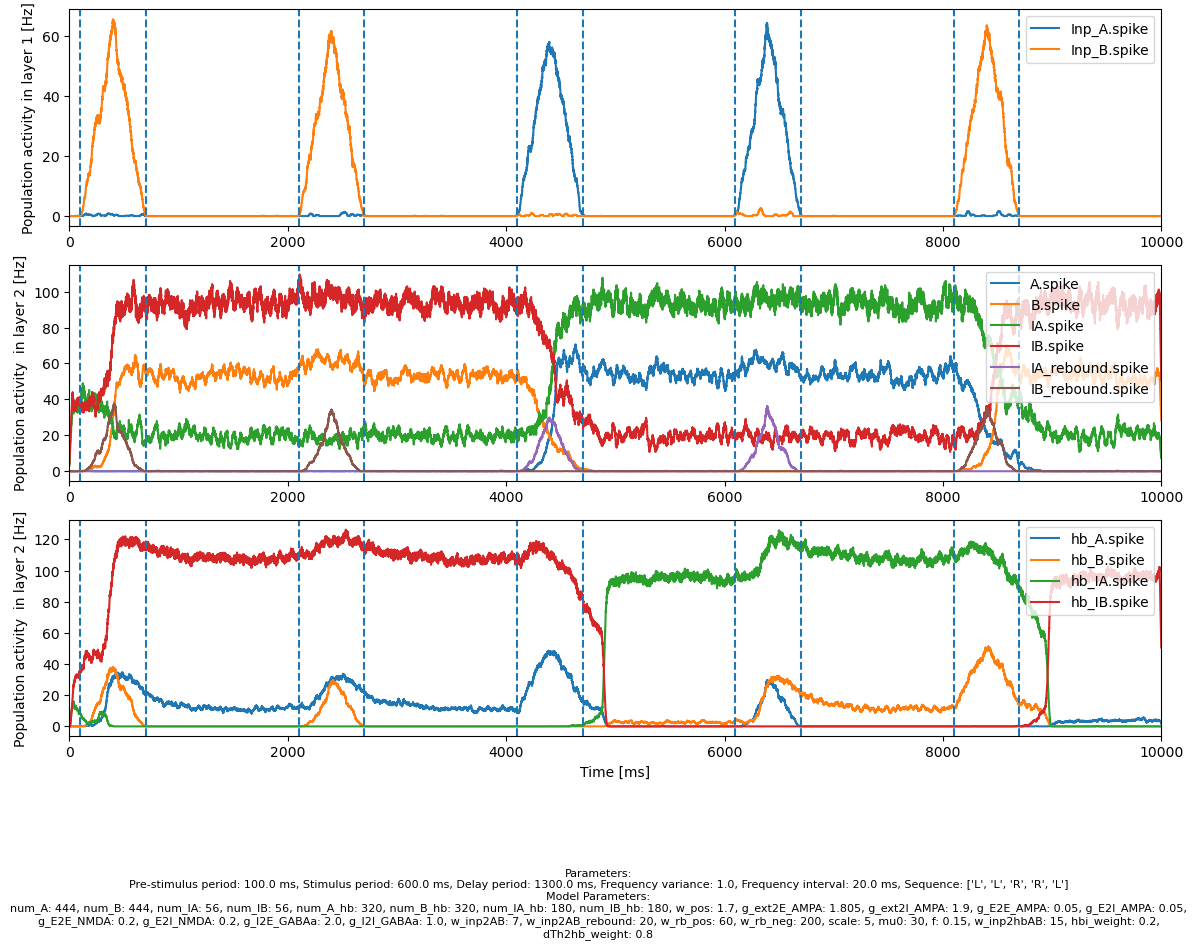

In [ ]:
# Paramters
params = {
    'num_A': 888 // 2,
    'num_B': 888 // 2,
    'num_IA': 112 // 2,
    'num_IB': 112 // 2,
    'num_A_hb': 640 // 2,
    'num_B_hb': 640 // 2,
    'num_IA_hb': 360 // 2,
    'num_IB_hb': 360 // 2,
    'w_pos': 1.7,
    'g_ext2E_AMPA': 1.805,
    'g_ext2I_AMPA': 1.9,
    'g_E2E_AMPA': 0.05,
    'g_E2I_AMPA': 0.05,
    'g_E2E_NMDA': 0.2,
    'g_E2I_NMDA': 0.2,
    'g_I2E_GABAa': 2.0,
    'g_I2I_GABAa': 1.0,
    'w_inp2AB': 7,
    'w_inp2AB_rebound': 20,
    'w_rb_pos': 60,
    'w_rb_neg': 200,
    'scale': 5,
    'mu0': 30,
    'f': 0.15,
    'w_inp2hbAB': 15,
    'hbi_weight': 0.2,
    'dTh2hb_weight': 0.8,
}

# calculate firing rate
def calculate_firing_rate(names, runner):
    num_neurons = runner.mon[names[0] + '.spike'].shape[1]
    rates = []
    for i in tqdm.tqdm(range(num_neurons), desc=f"Calculating firing rates for {names[0]}"):
        rates.append(bp.measure.firing_rate(runner.mon[names[0] + '.spike'][:, i].reshape(-1, 1), width=30.))
    return np.asarray(rates)

def average_with_timebins(rate, time_bin):
    num_bins = rate.shape[1] // time_bin
    rate_bin = rate.reshape(rate.shape[0], num_bins, time_bin)
    rate_bin = np.mean(rate_bin, axis=2)
    return rate_bin



# generate sequences
seqs = ['L', 'L', 'R', 'R', 'L']

# build model
net = DecisionMakingNet(params=params, scale=params['scale'])

# generate inputs
def give_input():
    i = bp.share['i']
    net.Inp_A.freqs[0] = IA_freqs[i]
    net.Inp_B.freqs[0] = IB_freqs[i]


tool = Tool(seq=seqs)
mu0 = params['mu0']
coherence = 100.
IA_freqs = tool.generate_freqs(R=mu0 + mu0 / 100. * coherence, L=mu0 - mu0 / 100. * coherence)
IB_freqs = tool.generate_freqs(R=mu0 - mu0 / 100. * coherence, L=mu0 + mu0 / 100. * coherence)

# simulation
monlist = [ 'Inp_A.spike', 'Inp_B.spike', 'A.spike', 'B.spike', 'IA.spike', 'IB.spike',
            'IA_rebound.spike', 'IB_rebound.spike', 'hb_A.spike', 'hb_B.spike', 'hb_IA.spike', 'hb_IB.spike']
runner = bp.DSRunner(net, inputs=give_input, monitors=monlist)
runner.run(tool.total_period)

pltlist = ['Inp_A', 'Inp_B', 'A', 'B', 'IA', 'IB', 'IA_rebound', 'IB_rebound',
           'hb_A', 'hb_B', 'hb_IA', 'hb_IB']
tool.visualize_results(runner.mon, monlist, params, t_start=0., title='Decision Making Network', index=0, savefig=True, filename='decision_making_network_long1.pdf')

